## Coastal Mask

Notebook environment to migrate TIF files to CF compliant CoG

In [1]:
# Optional; code formatter, installed as jupyter lab extension
#%load_ext lab_black
# Optional; code formatter, installed as jupyter notebook extension
%load_ext nb_black

<IPython.core.display.Javascript object>

### Configure OS independent paths

In [2]:
# Import standard packages
import os
import pathlib
import sys
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from dotenv import load_dotenv
import math
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union
import rioxarray as rio
#load_dotenv()

# Import custom functionality
from coclicodata.drive_config import p_drive
from coclicodata.etl.cf_compliancy_checker import check_compliancy, save_compliancy
from coastmonitor.io.utils import name_block

# Define (local and) remote drives
coclico_data_dir = p_drive.joinpath("11207608-coclico", "FASTTRACK_DATA")

# Workaround to the Windows OS (10) udunits error after installation of cfchecker: https://github.com/SciTools/iris/issues/404
os.environ["UDUNITS2_XML_PATH"] = str(
    pathlib.Path().home().joinpath(  # change to the udunits2.xml file dir in your Python installation
        r"Anaconda3\pkgs\udunits2-2.2.28-h892ecd3_0\Library\share\udunits\udunits2.xml"
    )
)

# use local or remote data dir
use_local_data = False
ds_dirname = "19_coastal_mask"

if use_local_data: 
    ds_dir = pathlib.Path().home().joinpath("data", "tmp", ds_dirname)
else: 
    ds_dir = coclico_data_dir.joinpath(ds_dirname)

if not ds_dir.exists():
    raise FileNotFoundError("Directory with data does not exist.")

# directory to export result (make if not exists)
cog_dir = ds_dir.joinpath("cog") # for checking CF compliancy
cog_dirs = ds_dir.joinpath("cogs") # for making all files CF compliant
cog_dir.mkdir(parents=True, exist_ok=True)

C:\Users\kras\AppData\Local\Temp\ipykernel_12324\2464473686.py:6: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


<IPython.core.display.Javascript object>

In [3]:
# Project paths & files (manual input)
ds_path = ds_dir.joinpath("Global_merit_coastal_mask_landwards.tif")
CF_dir = coclico_data_dir.joinpath(r"CF")  # directory to save output CF check files

<IPython.core.display.Javascript object>

### Write data to CoG

In [4]:
# NetCDF attribute alterations by means of metadata template
import json
f_global = open(ds_dir.joinpath("metadata_coastal_mask.json"))
meta_global = json.load(f_global)

<IPython.core.display.Javascript object>

#### Single CoG test

In [30]:
def generate_slices(num_chunks: int, chunk_size: int) -> Tuple[slice, slice]:
    """Generate slices for chunk-based iteration."""
    for i in range(num_chunks):
        yield slice(i * chunk_size, (i + 1) * chunk_size)


cm = xr.open_dataset(
    ds_path, engine="rasterio", mask_and_scale=False
)  # .isel({"x":slice(0, 40000), "y":slice(0, 40000)})
cm = cm.assign_coords(band=("band", [f"B{k+1:02}" for k in range(cm.dims["band"])]))
cm = cm["band_data"].to_dataset("band")

# chunk size 
chunk_size = 2**12 # 16384, which is large, but OK for int8 datatype.

cm_chunked = cm.chunk({"x": chunk_size, "y": chunk_size})

num_x_chunks = math.ceil(cm_chunked.dims["x"] / chunk_size)
num_y_chunks = math.ceil(cm_chunked.dims["y"] / chunk_size)

for x_slice in generate_slices(num_x_chunks, chunk_size):
    for y_slice in generate_slices(num_y_chunks, chunk_size):
        chunk = cm_chunked.isel(x=x_slice, y=y_slice)

        chunk = chunk.assign_coords(time=pd.Timestamp(2022, 2, 22).isoformat())

        for var in chunk:
            da = chunk[var]

            da = (
                da.where(da != -9999, 0)
                .astype("uint8")
                .rio.write_nodata(0)
                .rio.set_spatial_dims(x_dim="x", y_dim="y")
            )

            item_name = name_block(
                da,
                storage_prefix="",
                name_prefix="",
                include_band=da.name,
                time_dim=False,
                x_dim="x",
                y_dim="y",
            )

            # convert to dataset
            dad = da.to_dataset()

            # add all attributes (again)
            for attr_name, attr_val in meta_global.items():
                if attr_name == 'PROVIDERS':
                    attr_val = json.dumps(attr_val)
                if attr_name == "MEDIA_TYPE": # change media type to tiff, leave the rest as is
                    attr_val = "IMAGE/TIFF"
                dad.attrs[attr_name] = attr_val

            dad.attrs['Conventions'] = "CF-1.8"

            # export file
            outpath = cog_dir.joinpath(item_name)
            dad.rio.to_raster(outpath, compress="DEFLATE", driver="COG")

        break
    break

CPLE_AppDefinedError: Deleting P:/11207608-coclico/FASTTRACK_DATA/19_coastal_mask/cog/B01_x-180.0_y81.59.tif failed: Permission denied

<IPython.core.display.Javascript object>

In [6]:
# export to nc for quick CF compliancy check..
dad.to_netcdf(path=cog_dir.joinpath(item_name.replace(".tif", ".nc")))

<IPython.core.display.Javascript object>

In [7]:
%%capture cap --no-stderr
# check original CF compliancy

check_compliancy(testfile=cog_dir.joinpath(item_name.replace(".tif", ".nc")), working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [8]:
# save original CF compliancy
save_compliancy(cap, testfile=cog_dir.joinpath(item_name.replace(".tif", ".nc")), working_dir=CF_dir)

{'P:\\11207608-coclico\\FASTTRACK_DATA\\19_coastal_mask\\cog\\B01_x-180.0_y81.59.nc': {'warnings': '8', 'errors': '1'}}


<IPython.core.display.Javascript object>

##### Note, the CF compliancy check here gives warnings & errors for the NC files because we actually did not focus on making it CF complaint. The file was delivered as TIFF and will be outputted as TIFF. Hence, there is actually no need in making a NC file. TIFFs are way less flexible in variables and therefore no CF compliancy check is needed. Data will always be an array with band, y, x as dimensions and band, y, x, spatial_ref as coordinates

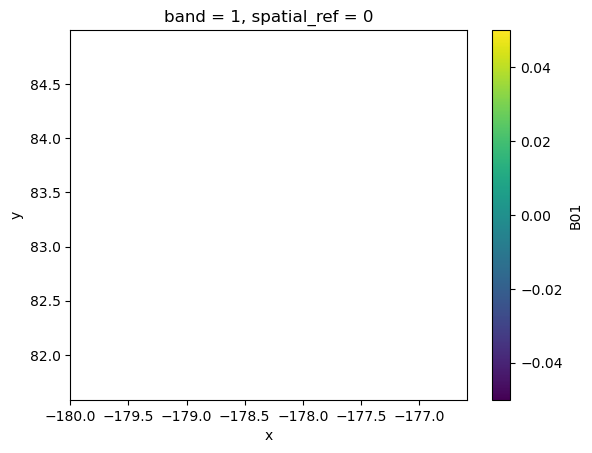

<IPython.core.display.Javascript object>

In [9]:
# plot to check output
data = rio.open_rasterio(outpath, masked=True)
data.plot()
#rds.plot()

In [11]:
data

<xarray.DataArray (band: 1, y: 4096, x: 4096)>
[16777216 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -180.0 -180.0 -180.0 ... -176.6 -176.6 -176.6
  * y            (y) float64 85.0 85.0 85.0 85.0 ... 81.59 81.59 81.59 81.59
    spatial_ref  int32 0
Attributes: (12/13)
    AREA_OR_POINT:    Area
    Conventions:      CF-1.8
    CRS:              EPSG:4326
    HISTORY:          ['Deltares', '']
    KEYWORDS:         ['']
    MEDIA_TYPE:       IMAGE/TIFF
    ...               ...
    SPATIAL_EXTENT:   [-180, -90, 180, 90]
    TAGS:             ['']
    TEMPORAL_EXTENT:  ['', '']
    scale_factor:     1.0
    add_offset:       0.0
    long_name:        B01

<IPython.core.display.Javascript object>

#### Multiple CoGs

In [43]:
from datacube.utils.cog import write_cog
def generate_slices(num_chunks: int, chunk_size: int) -> Tuple[slice, slice]:
    """Generate slices for chunk-based iteration."""
    for i in range(num_chunks):
        yield slice(i * chunk_size, (i + 1) * chunk_size)


cm = xr.open_dataset(
    ds_path, engine="rasterio", mask_and_scale=False
)  # .isel({"x":slice(0, 40000), "y":slice(0, 40000)})
cm = cm.assign_coords(band=("band", [f"B{k+1:02}" for k in range(cm.dims["band"])]))
cm = cm["band_data"].to_dataset("band")

# chunk size 
chunk_size = 2**12 # 16384, which is large, but OK for int8 datatype.

cm_chunked = cm.chunk({"x": chunk_size, "y": chunk_size})

num_x_chunks = math.ceil(cm_chunked.dims["x"] / chunk_size)
num_y_chunks = math.ceil(cm_chunked.dims["y"] / chunk_size)

for x_slice in generate_slices(num_x_chunks, chunk_size):
    for y_slice in generate_slices(num_y_chunks, chunk_size):
        chunk = cm_chunked.isel(x=x_slice, y=y_slice)

        chunk = chunk.assign_coords(time=pd.Timestamp(2022, 2, 22).isoformat())

        for var in chunk:
            print(x_slice, y_slice)

            da = chunk[var]

            da = (
                da.where(da != -9999, 0)
                .astype("uint8")
                .rio.write_nodata(0)
                .rio.set_spatial_dims(x_dim="x", y_dim="y")
            )

            item_name = name_block(
                da,
                storage_prefix="",
                name_prefix="",
                include_band=da.name,
                time_dim=False,
                x_dim="x",
                y_dim="y",
            )

            print(item_name)

            # convert to dataset
            dad = da.to_dataset()

            # add all attributes (again)
            # for attr_name, attr_val in meta_global.items():
            #     if attr_name == 'PROVIDERS':
            #         attr_val = json.dumps(attr_val)
            #     if attr_name == "MEDIA_TYPE": # change media type to tiff, leave the rest as is
            #         attr_val = "IMAGE/TIFF"
            #     dad.attrs[attr_name] = attr_val

            # dad.attrs['Conventions'] = "CF-1.8"

            # make parent dir if not exists
            outpath = cog_dirs.joinpath(item_name)
            outpath.parent.mkdir(parents=True, exist_ok=True)

            # export file
            dad.rio.to_raster(outpath, compress="DEFLATE", driver="COG")

            # set overwrite is false because tifs should be unique
            # try:
            #     write_cog(da, fname=outpath, overwrite=False).compute()
            # except OSError as e:
            #     continue

slice(0, 4096, None) slice(0, 4096, None)
B01_x-180.0_y81.59.tif
slice(0, 4096, None) slice(4096, 8192, None)
B01_x-180.0_y78.17.tif
slice(0, 4096, None) slice(8192, 12288, None)
B01_x-180.0_y74.76.tif
slice(0, 4096, None) slice(12288, 16384, None)
B01_x-180.0_y71.35.tif
slice(0, 4096, None) slice(16384, 20480, None)
B01_x-180.0_y67.93.tif
slice(0, 4096, None) slice(20480, 24576, None)
B01_x-180.0_y64.52.tif
slice(0, 4096, None) slice(24576, 28672, None)
B01_x-180.0_y61.11.tif
slice(0, 4096, None) slice(28672, 32768, None)
B01_x-180.0_y57.69.tif
slice(0, 4096, None) slice(32768, 36864, None)
B01_x-180.0_y54.28.tif
slice(0, 4096, None) slice(36864, 40960, None)
B01_x-180.0_y50.87.tif
slice(0, 4096, None) slice(40960, 45056, None)
B01_x-180.0_y47.45.tif
slice(0, 4096, None) slice(45056, 49152, None)
B01_x-180.0_y44.04.tif


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [ ]:
# %%capture cap --no-stderr
# # check original CF compliancy

# check_compliancy(testfile=cog_dir.joinpath(item_name.replace(".tif", ".nc")), working_dir=CF_dir)

In [ ]:
# save original CF compliancy
# save_compliancy(cap, testfile=cog_dir.joinpath(item_name.replace(".tif", ".nc")), working_dir=CF_dir)